# Assignment 2 - Non Textual Data
## Authors: Javier Arteaga Puell, Rodrigo Castañón Martínez, Dakota Mellish

In [1]:
import cv2 as cv
import numpy as np
import os
import pytesseract
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [2]:
# Load all images from the "img" folder
images = {}
for file in os.listdir("img"):
    if file.endswith(".jpg") or file.endswith(".png"):
        images[file] = cv.imread(os.path.join("img", file), cv.IMREAD_COLOR)

total_images = len(images)

In [ ]:
# Function to retrieve the jersey name from a CSV file
def fetch_jersey_name_from_csv(jersey_number, csv_path="all_jerseys.csv"):
    df = pd.read_csv(csv_path)
    if "Jersey Name" not in df.columns:
        raise ValueError("La columna 'Jersey Name' no existe en el archivo CSV.")
    
    if jersey_number < 1 or jersey_number > len(df):
        raise IndexError("El número de jersey está fuera del rango del CSV.")

    return df.iloc[jersey_number]["Jersey Name"]

In [4]:
# Function to remove the background from an image
def extract_foreground(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    lower_bound = np.array([0, 0, 200], dtype=np.uint8)
    upper_bound = np.array([180, 50, 255], dtype=np.uint8)
    
    # Create a mask to remove background
    mask = cv.inRange(hsv, lower_bound, upper_bound)
    mask_inv = cv.bitwise_not(mask)  

    # Apply mask to original image
    result = cv.bitwise_and(image, image, mask=mask_inv)
    
    return result

# Smart Histogram Descriptor

In [5]:
# Function to divide an image into sub-images
def split_image_into_regions(image, row_sizes: list, col_sizes: list):
     return [image[row_start:row_end, col_start:col_end] 
            for row_start, row_end in zip(row_sizes[:-1], row_sizes[1:])
            for col_start, col_end in zip(col_sizes[:-1], col_sizes[1:])]

In [6]:
# Function to compute histograms for each sub-image
def compute_histograms_per_region(imgs):
    hists = {name: [[cv.calcHist([sub_img], [i], None, [256], [0, 256]) 
                     for i in range(3)] for sub_img in img] 
             for name, img in imgs.items()}
    return hists

In [7]:
# Function to calculate the distance between two histogram sub-images
def compute_histogram_distance(sub_img1, sub_img2):
    return np.mean([cv.compareHist(h1, h2, cv.HISTCMP_CHISQR) for h1, h2 in zip(sub_img1, sub_img2)])

In [8]:
# Function to calculate the total distance between two images
def compute_total_image_distance(img1, img2):
   # Define weights explicitly for readability
    weights = [0.15] + [0.1 / 12] * 4 + [0.1 / 12, 0.6 / 6, 0.6 / 6, 0.6 / 6, 0.1 / 12] * 2 + [0.1 / 12] * 4 + [0.15]

    # Compute weighted sum of histogram distances
    return sum(w * compute_histogram_distance(h1, h2) for h1, h2, w in zip(img1, img2, weights))

In [9]:
# Function to calculate distances for all images using histogram comparison
def compute_histogram_based_similarities(images, selected_img):
    images_divided = {name: split_image_into_regions(extract_foreground(image), row_sizes=[0, 125, 250, 500, 1000], col_sizes=[0, 125, 250, 500, 1000]) for name, image in images.items()}
    selected_img_processed = split_image_into_regions(extract_foreground(images[selected_img]), row_sizes=[0, 125, 250, 500, 1000], col_sizes=[0, 125, 250, 500, 1000])
    images_divided_hist = compute_histograms_per_region(images_divided)
    selected_img_hist = compute_histograms_per_region({selected_img: selected_img_processed})[selected_img]
    dist = {name: compute_total_image_distance(selected_img_hist, img2) for name, img2 in images_divided_hist.items()}
    return dist

In [10]:
#Choose a jersey and calculate
selected_img = 'jersey_10.jpg'
jersey_name = fetch_jersey_name_from_csv(10, "all_jerseys.csv")
distances_hist = compute_histogram_based_similarities(images, selected_img)
ordered_hist_distances = sorted(distances_hist.items(), key=lambda x: x[1])

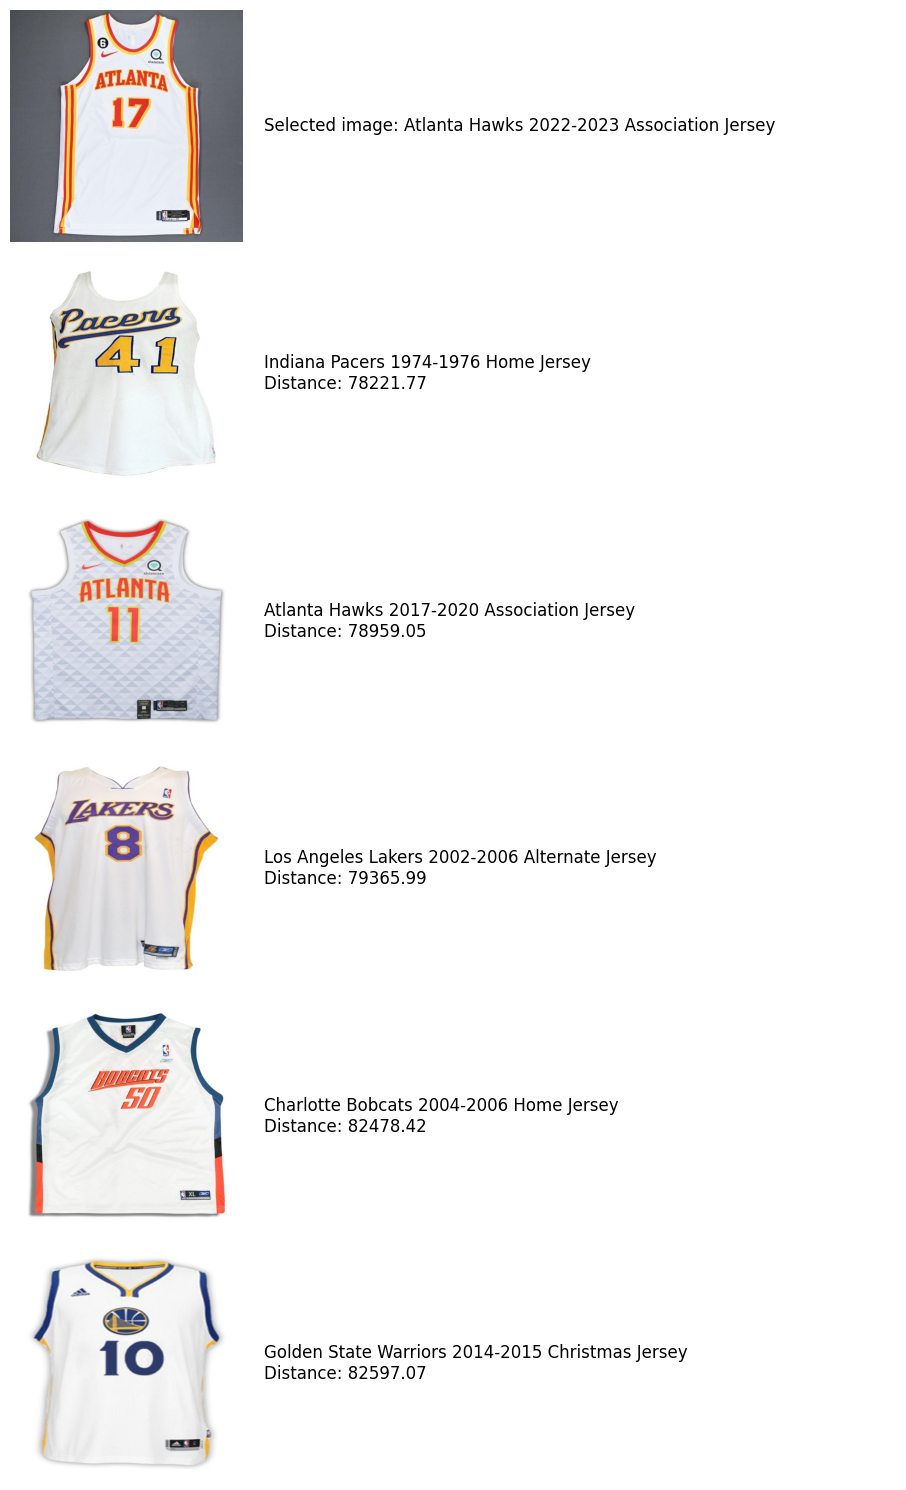

<Figure size 640x480 with 0 Axes>

In [11]:
#Plot the results
fig, ax = plt.subplots(len(ordered_hist_distances[:6]), 2, figsize=(10, 15), gridspec_kw={'width_ratios': [1, 2]})

ax[0, 0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0, 0].axis('off')
ax[0, 1].text(0, 0.5, f'Selected image: {jersey_name}', fontsize=12, verticalalignment='center')
ax[0, 1].axis('off')

for i in range(1, 6):
    ax[i, 0].imshow(cv.cvtColor(images[ordered_hist_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i, 0].axis('off')
    jersey_number = int(ordered_hist_distances[i][0].split("_")[1].split(".")[0])
    jersey_name = fetch_jersey_name_from_csv(jersey_number, "all_jerseys.csv")
    ax[i, 1].text(0, 0.5, f'{jersey_name}\nDistance: {ordered_hist_distances[i][1]:.2f}', fontsize=12, verticalalignment='center')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()
plt.clf()

# Histogram of Oriented Gradients Descriptor

In [12]:
# Function to extract the text region using OCR
def detect_text_area_via_OCR(image):
     if image is None:
        print("⚠️ Error: Image is None in extract_text_region()")
        return np.zeros((64, 128, 3), dtype=np.uint8) 
     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
     text = pytesseract.image_to_string(gray, config="--psm 6")
     text = " ".join(re.findall(r"[A-Za-z0-9]{2,}", text))

     _, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
     contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

     if not contours:
         print("⚠️ No se detectaron contornos en extract_text_region().")
         return np.zeros((64, 128, 3), dtype=np.uint8)

     largest_contour = max(contours, key=cv.contourArea)
     x, y, w, h = cv.boundingRect(largest_contour)

     text_region = image[y:y+h, x:x+w]

     return text_region


In [13]:
# Function to compute HOG descriptor
def extract_hog_features(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    fixed_size = (64, 128)  
    gray = cv.resize(gray, fixed_size)

    hog = cv.HOGDescriptor()
    descriptor = hog.compute(gray).flatten()

    hog_size = 8192
    if descriptor.shape[0] < hog_size:
        descriptor = np.pad(descriptor, (0, hog_size - descriptor.shape[0]), mode='constant')
    
    return descriptor

In [14]:
# Function to compute Harris corner detection
def extract_harris_corner_features(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    harris_response = cv.cornerHarris(gray, 2, 3, 0.04).flatten()

    harris_size = 8192  
    if harris_response.shape[0] < harris_size:
        harris_response = np.pad(harris_response, (0, harris_size - harris_response.shape[0]), mode='constant')
    else:
        harris_response = harris_response[:harris_size] 
    
    return harris_response

In [15]:
# Function to compute Euclidean distance between two vectors
def calculate_euclidean_distance(vec1, vec2):
    return euclidean(vec1, vec2)

In [16]:
# Function to compare text features using HOG and Harris
def calculate_hog_harris_similarities(images, selected_img):
    selected_text_region = detect_text_area_via_OCR(images[selected_img])
    
    if selected_text_region is None:
        print(f"⚠️ No text detected in {selected_img}. Skipping similarity computation.")
        return {}

    # Extract HOG and Harris features for the selected image
    selected_hog = extract_hog_features(selected_text_region)
    selected_harris = extract_harris_corner_features(selected_text_region)

    # Extract text region, HOG, and Harris features for all images
    features = {
        name: (
            detect_text_area_via_OCR(img),  # Extract text region
        )
        for name, img in images.items() if name != selected_img
    }

    # Filter out images where text region was not detected
    valid_features = {
        name: (extract_hog_features(text), extract_harris_corner_features(text))
        for name, (text,) in features.items() if text is not None
    }

    # Compute similarity using Euclidean distance
    similarities = {
        name: (calculate_euclidean_distance(selected_hog, hog) + 
               calculate_euclidean_distance(selected_harris, harris)) / 2
        for name, (hog, harris) in valid_features.items()
    }

    return similarities

In [17]:
#Choose a jersey and calculate
selected_img = 'jersey_1014.jpg'
jersey_name = fetch_jersey_name_from_csv(1014, "all_jerseys.csv")

distances_hog_harris = calculate_hog_harris_similarities(images, selected_img)
ordered_hog_harris_distances = sorted(distances_hog_harris.items(), key=lambda x: x[1])

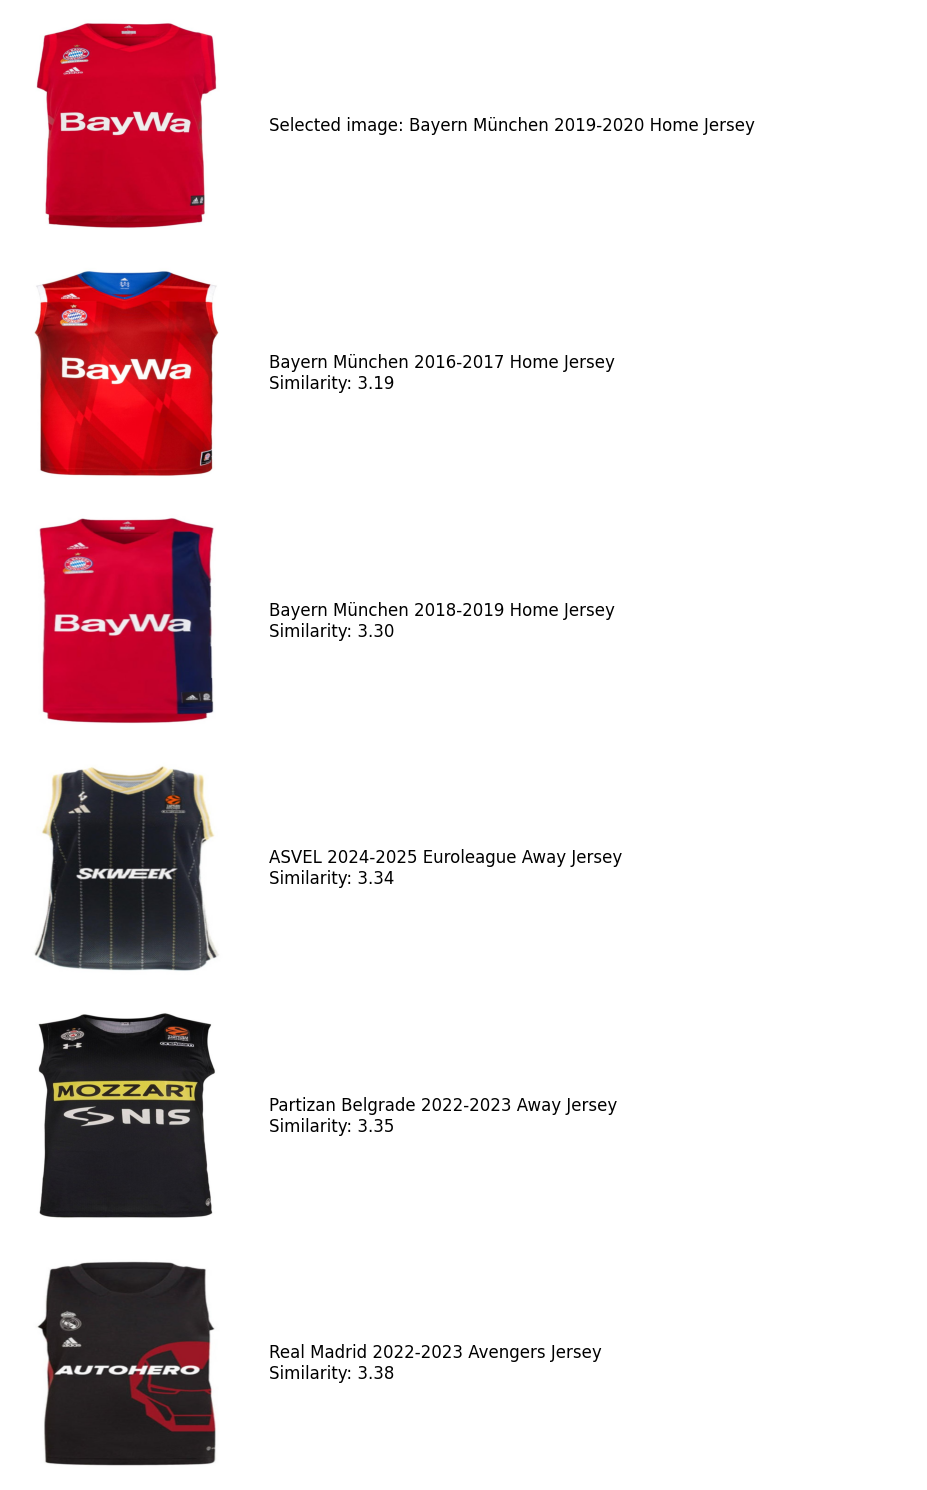

<Figure size 640x480 with 0 Axes>

In [18]:
#Plot the results
fig, ax = plt.subplots(len(ordered_hog_harris_distances[:6]), 2, figsize=(10, 15), gridspec_kw={'width_ratios': [1, 2]})
ax[0, 0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0, 0].axis('off')
ax[0, 1].text(0, 0.5, f'Selected image: {jersey_name}', fontsize=12, verticalalignment='center')
ax[0, 1].axis('off')

for i in range(1, 6):
    ax[i, 0].imshow(cv.cvtColor(images[ordered_hog_harris_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i, 0].axis('off')
    jersey_number = int(ordered_hog_harris_distances[i][0].split("_")[1].split(".")[0])
    jersey_name = fetch_jersey_name_from_csv(jersey_number, "all_jerseys.csv")
    ax[i, 1].text(0, 0.5, f'{jersey_name}\nSimilarity: {ordered_hog_harris_distances[i][1]:.2f}', fontsize=12, verticalalignment='center')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()
plt.clf()

# Combining both descriptors
### First Smart then HOG Histogram

In [19]:
# Choose a jersey
selected_img = 'jersey_359.jpg'
jersey_name = fetch_jersey_name_from_csv(359, "all_jerseys.csv")

In [20]:
# Normalized both distances
normalized_hist_distances = {name: dist / ordered_hist_distances[-1][1]  for name, dist in distances_hist.items()}
normalized_hog_distances = {name: dist / ordered_hog_harris_distances[-1][1] for name, dist in distances_hog_harris.items()}

ordered_normalized_hog_distances = sorted(normalized_hog_distances.items(), key=lambda x: x[1])
ordered_normalized_hist_distances = sorted(normalized_hist_distances.items(), key=lambda x: x[1])


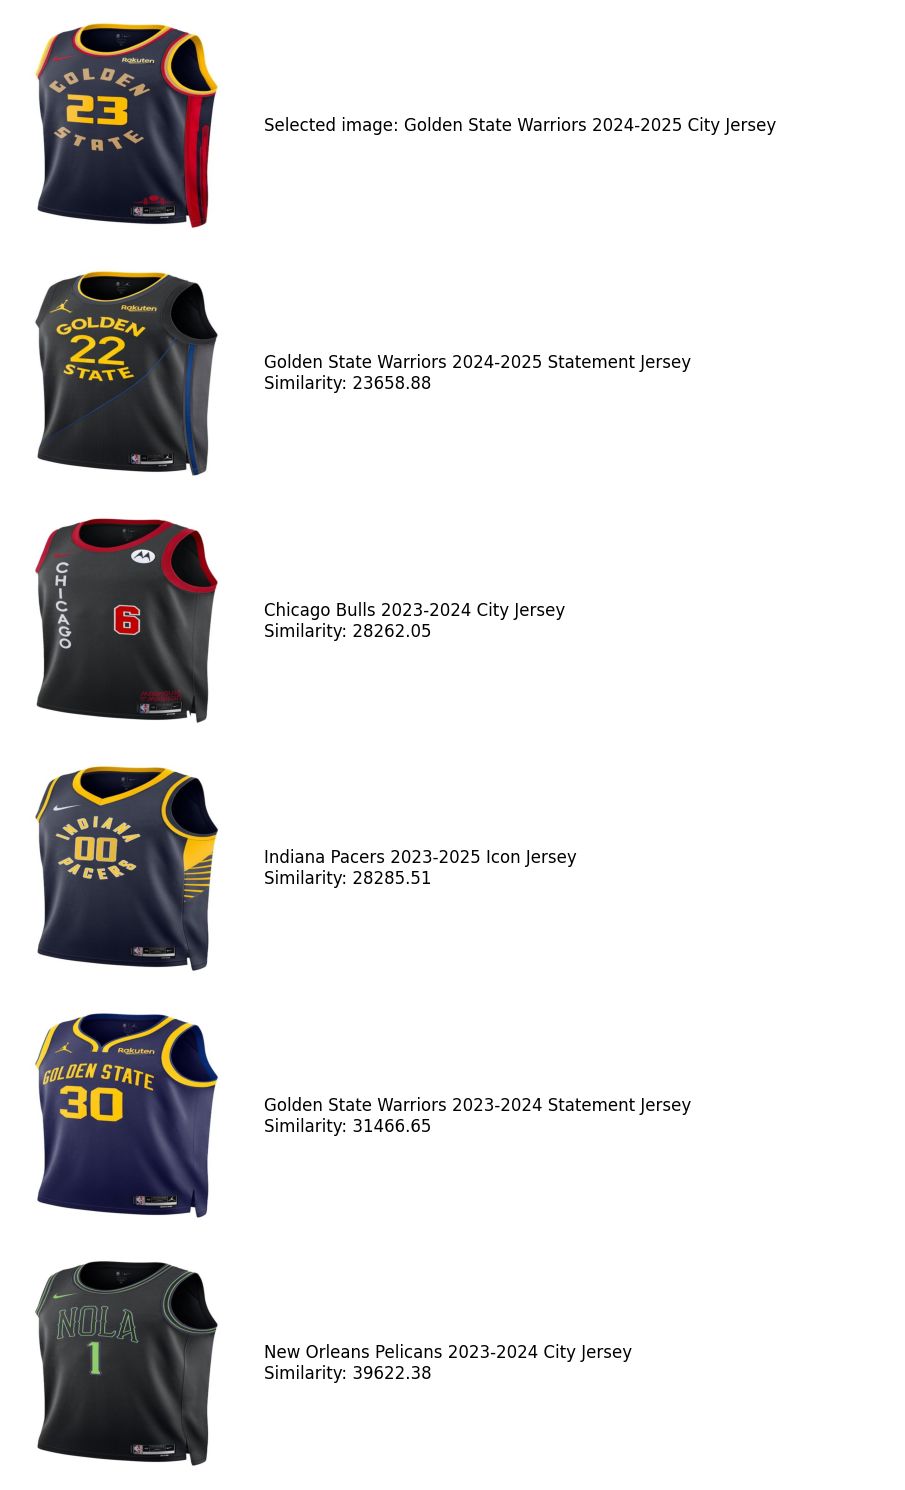

<Figure size 640x480 with 0 Axes>

In [21]:
#Calculate and plot the results
number_of_best_images = 1000
best_images_combination = {
    img_name: images[img_name]
    for img_name, _ in ordered_normalized_hist_distances[:number_of_best_images]
}


distances_hog_best_images = compute_histogram_based_similarities(best_images_combination, selected_img)
ordered_hog_distances = sorted(distances_hog_best_images.items(), key=lambda x: x[1])

fig, ax = plt.subplots(6, 2, figsize=(10, 15), gridspec_kw={'width_ratios': [1, 2]}) 

ax[0, 0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0, 0].axis('off')
ax[0, 1].text(0, 0.5, f'Selected image: {jersey_name}', fontsize=12, verticalalignment='center')
ax[0, 1].axis('off')

for i in range(1, 6):
    ax[i, 0].imshow(cv.cvtColor(images[ordered_hog_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i, 0].axis('off')
    jersey_number = int(ordered_hog_distances[i][0].split("_")[1].split(".")[0])
    jersey_name = fetch_jersey_name_from_csv(jersey_number, "all_jerseys.csv")
    ax[i, 1].text(0, 0.5, f'{jersey_name}\nSimilarity: {ordered_hog_distances[i][1]:.2f}', fontsize=12, verticalalignment='center')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()
plt.clf()

### First HOG then Smart Histogram

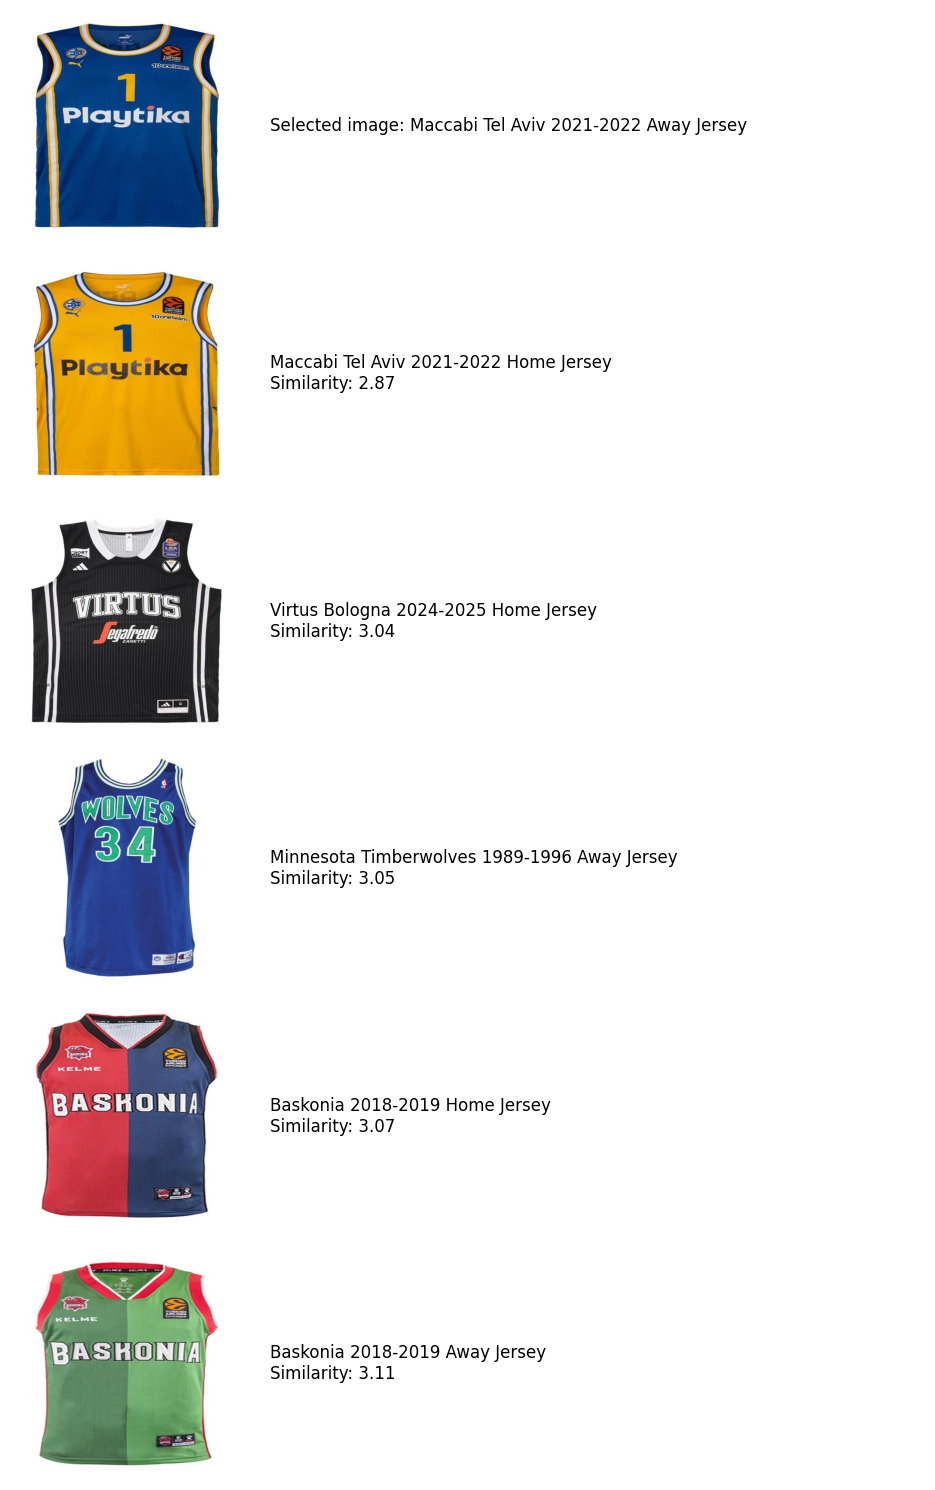

<Figure size 640x480 with 0 Axes>

In [22]:
# Calculate and plot the results
selected_img = 'jersey_1035.jpg'
jersey_name = fetch_jersey_name_from_csv(1035, "all_jerseys.csv")
num_best = min(number_of_best_images, len(ordered_normalized_hog_distances))  # Prevent IndexError
best_images_combination = {
    name: images[name] for name, _ in ordered_normalized_hog_distances[:num_best]
}

distances_hist_best_images = calculate_hog_harris_similarities(best_images_combination, selected_img)
ordered_hist_distances = sorted(distances_hist_best_images.items(), key=lambda x: x[1])

fig, ax = plt.subplots(6, 2, figsize=(10, 15), gridspec_kw={'width_ratios': [1, 2]}) 

ax[0, 0].imshow(cv.cvtColor(images[selected_img], cv.COLOR_BGR2RGB))
ax[0, 0].axis('off')
ax[0, 1].text(0, 0.5, f'Selected image: {jersey_name}', fontsize=12, verticalalignment='center')
ax[0, 1].axis('off')

for i in range(1, 6):
    ax[i, 0].imshow(cv.cvtColor(images[ordered_hist_distances[i][0]], cv.COLOR_BGR2RGB))
    ax[i, 0].axis('off')
    jersey_number = int(ordered_hist_distances[i][0].split("_")[1].split(".")[0])
    jersey_name = fetch_jersey_name_from_csv(jersey_number, "all_jerseys.csv")
    ax[i, 1].text(0, 0.5, f'{jersey_name}\nSimilarity: {ordered_hist_distances[i][1]:.2f}', fontsize=12, verticalalignment='center')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()
plt.clf()